In [164]:
# Milestone 0: Load libs & datasets
import pandas as pd, numpy as np
import plotly.express as px, plotly.graph_objects as go
import seaborn as sns, matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster




In [165]:
!pip install kaleido==0.2.1



In [166]:
# milstone 0 - importing 
p1 = '/kaggle/input/delhihel/MLDelhi2022.csv'
p2 = '/kaggle/input/delhihel/Delhi_AQI_2018-2024.csv'

df = pd.read_csv(p1, low_memory=False)
df_aqi = pd.read_csv(p2, low_memory=False)

# Standardize timestamp & quick shapes
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df_aqi['Timestamp'] = pd.to_datetime(df_aqi['Timestamp'], errors='coerce')
print('MLDelhi2022:', df.shape)
print('Delhi_AQI_2018-2024:', df_aqi.shape)

# Quick head + null summary (save small csv)
# df.head()
df.isna().sum().sort_values(ascending=False).head(20).to_csv('/kaggle/working/missing2022_top20.csv')
df_aqi.isna().sum().sort_values(ascending=False).to_csv('/kaggle/working/missing_aqi.csv')

df.head()

MLDelhi2022: (56606, 19)
Delhi_AQI_2018-2024: (76275, 5)


Timestamp  Year  Month  Day  DayOfWeek    DayName MonthName  PM2.5 (µg/m³)  \
0 2018-01-01  2018    1.0    1        0.0     Monday   January         317.88   
1 2018-01-02  2018    1.0    2        1.0    Tuesday   January         359.79   
2 2018-01-03  2018    1.0    3        2.0  Wednesday   January         197.22   
3 2018-01-04  2018    1.0    4        3.0   Thursday   January         223.66   
4 2018-01-05  2018    1.0    5        4.0     Friday   January         224.11   

   PM10 (µg/m³)  NO (µg/m³)  NO2 (µg/m³)  NH3 (µg/m³)  SO2 (µg/m³)  \
0        522.45       15.66        32.17        34.81        10.62   
1        628.01       15.42        31.39        34.81        10.62   
2        345.99       16.31        28.28        34.81        10.62   
3        323.67       16.58        30.41        34.81        10.62   
4        330.63       16.50        30.36        34.81        10.62   

   CO (mg/m³)  Ozone (µg/m³)         AQI         site_clean        lat  \
0        1.12          28.93  427.851621  CRRI_Mathura_Road  28.550093   
1        1.11          28.27  444.454622  CRRI_Mathura_Road  28.550093   
2        1.32          20.65  359.775058  CRRI_Mathura_Road  28.550093   
3        1.29          26.10  379.925635  CRRI_Mathura_Road  28.550093   
4        1.28          24.81  380.268591  CRRI_Mathura_Road  28.550093   

         lon  
0  77.275156  
1  77.275156  
2  77.275156  
3  77.275156  
4  77.275156

In [167]:
# Milstone-1
# preprocessing 

df.columns = (
    df.columns.str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace('(', '')
    .str.replace(')', '')
    .str.replace('/', '_')
    .str.replace('.', '')
)

# 2. Rename pollutant columns EXACTLY so detection is 100% clean

rename_map = {
    'pm25_µg_m³': 'pm25',
    'pm10_µg_m³': 'pm10',
    'no_µg_m³': 'no',
    'no2_µg_m³': 'no2',
    'nh3_µg_m³': 'nh3',
    'so2_µg_m³': 'so2',
    'co_mg_m³': 'co',
    'ozone_µg_m³': 'ozone',
}

df = df.rename(columns=rename_map)


# 3. Extract datetime features

df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5,6])

# Season
season_map = {
    12:'Winter',1:'Winter',2:'Winter',
    3:'Spring',4:'Spring',
    5:'Summer',6:'Summer',
    7:'Monsoon',8:'Monsoon',
    9:'Autumn',10:'Autumn',11:'Autumn'
}
df['season'] = df['month'].map(season_map)

# 
# 4. SAFE pollutant selection
#
pollutants = ['pm25','pm10','no','no2','nh3','so2','co','ozone']
pollutants = [p for p in pollutants if p in df.columns]

print("Detected pollutant columns:", pollutants)

# 
# 5. Impute pollutants safely
# 
df = df.sort_values('timestamp')

for col in pollutants:
    # numeric check
    df[col] = pd.to_numeric(df[col], errors='coerce')

    missing_ratio = df[col].isna().mean()

    if missing_ratio <= 0.20:
        # time-based interpolation only when using timestamp index
        temp = df[['timestamp', col]].drop_duplicates(subset=['timestamp'])
        temp = temp.set_index('timestamp')[col].interpolate('time')
        df[col] = df['timestamp'].map(temp)
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col + '_needs_impute'] = True

# 
# 6. Export cleaned version
# 
df.to_csv('/kaggle/working/MLDelhi2022_preprocessed.csv', index=False)

# df.iloc[2000]
df.head()

Detected pollutant columns: ['pm25', 'pm10', 'no', 'no2', 'nh3', 'so2', 'co', 'ozone']


timestamp  year  month  day  dayofweek dayname monthname    pm25  \
0     2018-01-01  2018      1    1          0  Monday   January  317.88   
21912 2018-01-01  2018      1    1          0  Monday   January  317.88   
32868 2018-01-01  2018      1    1          0  Monday   January  317.88   
23738 2018-01-01  2018      1    1          0  Monday   January  317.88   
14608 2018-01-01  2018      1    1          0  Monday   January  317.88   

         pm10     no  ...    so2    co  ozone         aqi          site_clean  \
0      522.45  15.66  ...  10.62  1.12  28.93  427.851621   CRRI_Mathura_Road   
21912  522.45  15.66  ...  10.62  1.12  28.93  427.273229     R_K_Puram_Delhi   
32868  522.45  15.66  ...  10.62  1.12  28.93  162.506805        Narela_Delhi   
23738  522.45  15.66  ...  10.62  1.12  28.93  474.047659  Punjabi_Bagh_Delhi   
14608  522.45  15.66  ...  10.62  1.12  28.93  386.129330      ITO_Delhi_CPCB   

             lat        lon  hour  is_weekend  season  
0      28.550093  77.275156     0       False  Winter  
21912  28.550380  77.185523     0       False  Winter  
32868  28.822711  77.125775     0       False  Winter  
23738  28.655415  77.047835     0       False  Winter  
14608  28.629641  77.241061     0       False  Winter  

[5 rows x 22 columns]

In [168]:
# milestone 2

# input 
clean_path = "/kaggle/working/MLDelhi2022_preprocessed.csv"
aqi_path   = "/kaggle/input/delhihel/Delhi_AQI_2018-2024.csv"

df = pd.read_csv(clean_path, parse_dates=["timestamp"])
df_aqi = pd.read_csv(aqi_path, parse_dates=["Timestamp"])
df_aqi.columns = df_aqi.columns.str.lower().str.strip()

print(df.shape)
print(df_aqi.shape)

df.head()


(56606, 22)
(76275, 5)


timestamp  year  month  day  dayofweek dayname monthname    pm25    pm10  \
0 2018-01-01  2018      1    1          0  Monday   January  317.88  522.45   
1 2018-01-01  2018      1    1          0  Monday   January  317.88  522.45   
2 2018-01-01  2018      1    1          0  Monday   January  317.88  522.45   
3 2018-01-01  2018      1    1          0  Monday   January  317.88  522.45   
4 2018-01-01  2018      1    1          0  Monday   January  317.88  522.45   

      no  ...    so2    co  ozone         aqi          site_clean        lat  \
0  15.66  ...  10.62  1.12  28.93  427.851621   CRRI_Mathura_Road  28.550093   
1  15.66  ...  10.62  1.12  28.93  427.273229     R_K_Puram_Delhi  28.550380   
2  15.66  ...  10.62  1.12  28.93  162.506805        Narela_Delhi  28.822711   
3  15.66  ...  10.62  1.12  28.93  474.047659  Punjabi_Bagh_Delhi  28.655415   
4  15.66  ...  10.62  1.12  28.93  386.129330      ITO_Delhi_CPCB  28.629641   

         lon  hour  is_weekend  season  
0  77.275156     0       False  Winter  
1  77.185523     0       False  Winter  
2  77.125775     0       False  Winter  
3  77.047835     0       False  Winter  
4  77.241061     0       False  Winter  

[5 rows x 22 columns]

In [169]:

# BLOCK 2: Annual AQI Trend (2018–2024)


df_aqi['year'] = df_aqi['timestamp'].dt.year
annual = df_aqi.groupby('year')['aqi'].mean().reset_index()

fig = px.line(
    annual, x='year', y='aqi', markers=True,
    title='Mean Annual AQI (2018–2024)',
    template='plotly_white'
)
fig.update_traces(marker=dict(size=10, line=dict(width=2)))
fig.show()


Insights to add in slides:

AQI peaks every winter

Clear dip in 2020 (COVID lockdown)

Rising trend post-2021

In [170]:

# BLOCK 4: Weekday vs Weekend AQI


df_aqi['dayofweek'] = df_aqi['timestamp'].dt.dayofweek
df_aqi['is_weekend'] = df_aqi['dayofweek'].isin([5,6])

week = df_aqi.groupby('is_weekend')['aqi'].mean().reset_index()

fig = px.bar(
    week, x='is_weekend', y='aqi',
    labels={'is_weekend': 'Weekend (True/False)'},
    title='Average AQI: Weekend vs Weekday',
    template='plotly_white'
)
fig.show()


In [171]:

# BLOCK 3: Monthly AQI Seasonal Pattern


df_aqi['month'] = df_aqi['timestamp'].dt.month
monthly = df_aqi.groupby(['year','month'])['aqi'].mean().reset_index()

fig = px.line(
    monthly, x='month', y='aqi', color='year',
    title='Monthly AQI Cycles (Overlay by Year)',
    template='plotly_white'
)
fig.update_layout(legend_title="Year")
fig.show()


In [172]:

# BLOCK 3 — Beautiful AQI Map with Hover Labels


import folium
import pandas as pd

df_aqi = pd.read_csv("/kaggle/input/delhihel/Delhi_AQI_2018-2024.csv", parse_dates=["Timestamp"])
df_aqi.columns = df_aqi.columns.str.lower().str.strip()

# station-level AQI
site_avg = df_aqi.groupby('site_clean').agg({
    'aqi': 'mean',
    'lat': 'first',
    'lon': 'first'
}).reset_index()

# AQI color function
# color help for shashwat 
def aqi_color(aqi):
    if aqi <= 50:   return "#00e400"  # green
    elif aqi <= 100:return "#ffff00"  # yellow
    elif aqi <= 200:return "#ff7e00"  # orange
    elif aqi <= 300:return "#ff0000"  # red
    elif aqi <= 400:return "#8f3f97"  # purple
    else:           return "#7e0023"  # maroon

# Create clean modern map
m = folium.Map(
    location=[site_avg['lat'].mean(), site_avg['lon'].mean()],
    zoom_start=11,
    tiles="CartoDB Positron"
)

# Add CircleMarkers with tooltip labels
for _, r in site_avg.iterrows():
    folium.CircleMarker(
        location=[r['lat'], r['lon']],
        radius=9,
        color=aqi_color(r['aqi']),
        fill=True,
        fill_opacity=0.85,
        weight=2,
        tooltip=folium.Tooltip(
            text=f"{r['site_clean']}",
            sticky=True,
            direction="top",
            opacity=0.9
        ),
        popup=f"<b>{r['site_clean']}</b><br>AQI: {r['aqi']:.2f}"
    ).add_to(m)

m.save("/kaggle/working/Delhi_AQI_Map_Clean_Hover.html")
m


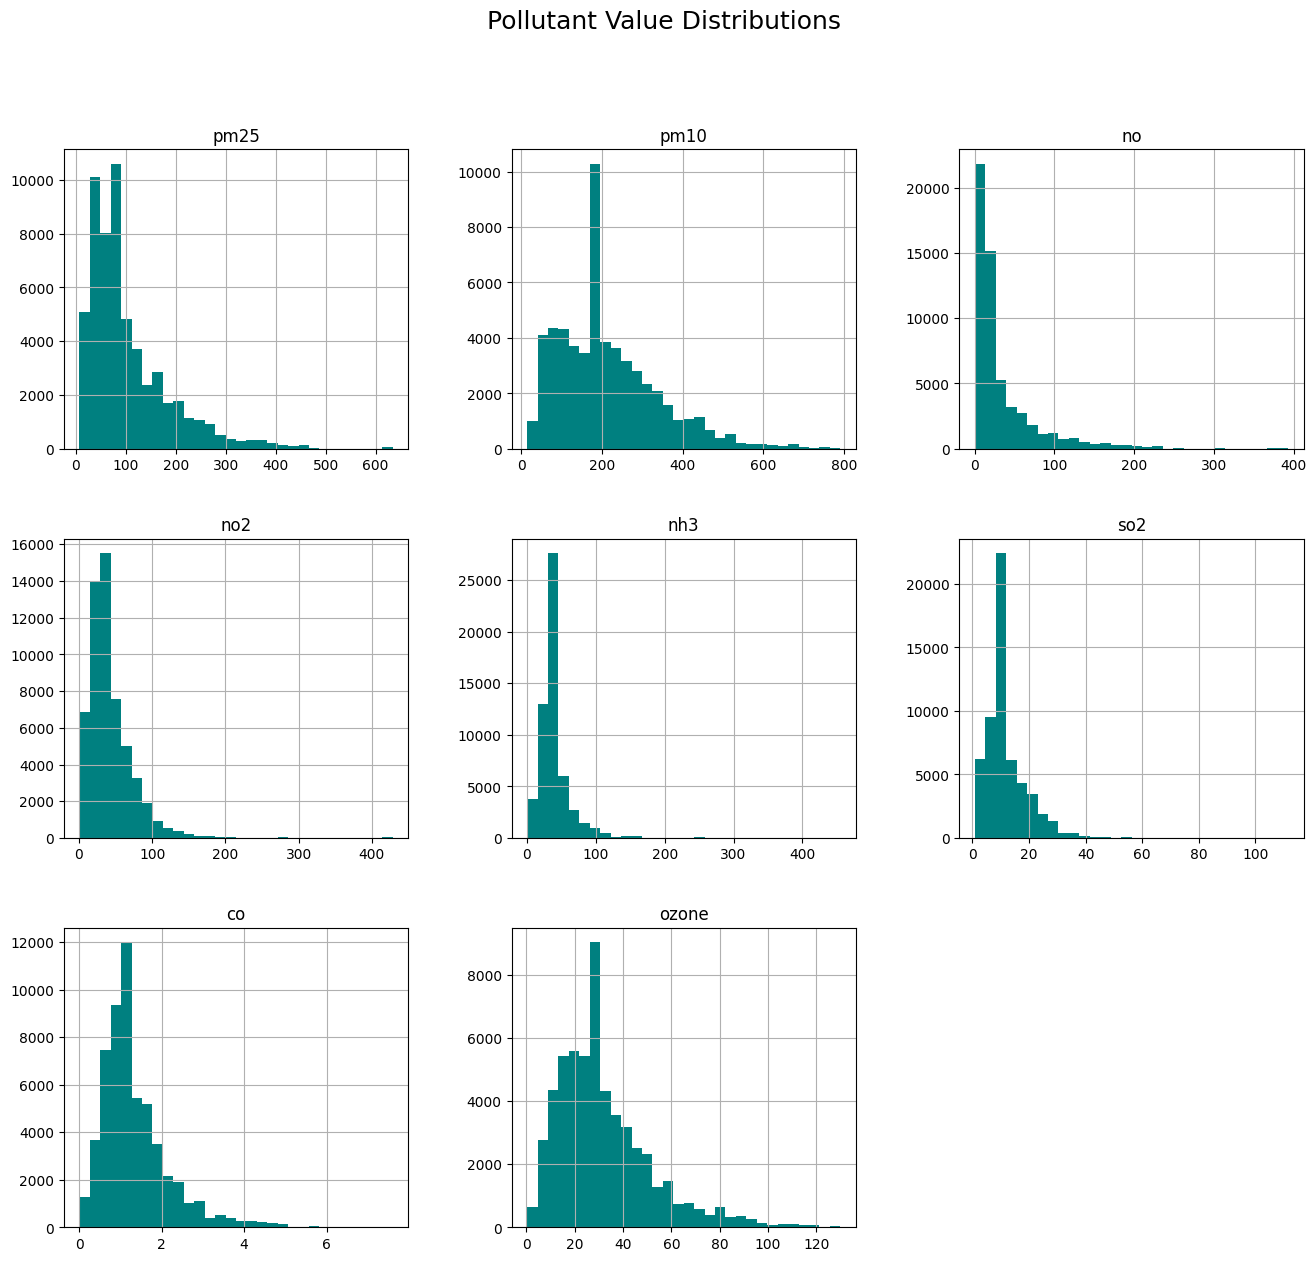

In [173]:

# BLOCK 6: Pollutant Distributions


polls = ['pm25','pm10','no','no2','nh3','so2','co','ozone']
df[polls].hist(bins=30, figsize=(16,14), color='teal')
plt.suptitle("Pollutant Value Distributions", fontsize=18)
plt.show()


In [174]:

# BLOCK 7: Correlation Heatmap


corr = df[polls].corr()

fig = px.imshow(
    corr, text_auto=".2f",
    title="Pollutant Correlation Matrix",
    template="plotly_white",
    color_continuous_scale='RdBu_r'
)
fig.show()


In [175]:
# 
# BLOCK A: Correlation of AQI vs Pollutants
# 

df = pd.read_csv('/kaggle/working/MLDelhi2022_preprocessed.csv', parse_dates=['timestamp'])

polls = ['pm25','pm10','no','no2','nh3','so2','co','ozone']

corr_aqi = df[polls + ['aqi']].corr()['aqi'].sort_values(ascending=False)
display(corr_aqi)


aqi      1.000000
pm25     0.750061
pm10     0.748330
co       0.469003
no       0.422440
no2      0.394909
nh3      0.220478
so2      0.142730
ozone   -0.063082
Name: aqi, dtype: float64

In [176]:
# 
# BLOCK B: Plotly Heatmap — AQI vs Pollutants Only
# 

import plotly.express as px

corr_matrix = df[polls + ['aqi']].corr()[['aqi']].drop('aqi')

fig = px.imshow(
    corr_matrix,
    text_auto=".2f",
    aspect="auto",
    color_continuous_scale='RdBu_r',
    title="Correlation of AQI with Individual Pollutants",
    template="plotly_white"
)
fig.update_layout(coloraxis_colorbar=dict(title="Correlation"))
fig.show()


In [177]:
# 
# BLOCK 1 — Event Impact (November + Diwali)
# 



# load fresh
df_aqi = pd.read_csv("/kaggle/input/delhihel/Delhi_AQI_2018-2024.csv", parse_dates=["Timestamp"])
df_aqi.columns = df_aqi.columns.str.lower().str.strip()

# Extract date parts safely
df_aqi['year']  = df_aqi['timestamp'].dt.year
df_aqi['month'] = df_aqi['timestamp'].dt.month
df_aqi['day']   = df_aqi['timestamp'].dt.day

# 
#  Crop Burning Impact (November)
# 
df_nov = df_aqi[df_aqi['month'] == 11]

nov_daily = df_nov.groupby('day')['aqi'].mean().reset_index()

fig = px.line(
    nov_daily, x='day', y='aqi',
    title='Average AQI in November (Crop Burning Season)',
    template='plotly_white', markers=True
)
fig.show()

# 
#  Diwali Impact (±7 days)
# 
diwali_dates = ['2018-11-07','2019-10-27','2020-11-14','2021-11-04','2022-10-24']
d_start = pd.to_datetime(diwali_dates) - pd.Timedelta(days=7)
d_end   = pd.to_datetime(diwali_dates) + pd.Timedelta(days=7)

mask = False
for s, e in zip(d_start, d_end):
    mask |= df_aqi['timestamp'].between(s, e)

df_diwali = df_aqi[mask]

diwali_daily = df_diwali.set_index('timestamp').resample('D')['aqi'].mean().reset_index()

fig2 = px.line(
    diwali_daily, x='timestamp', y='aqi',
    title="AQI Around Diwali (±7 Days)",
    template='plotly_white', markers=True
)
fig2.show()


In [178]:
# 
# BLOCK 2 — AQI Category Distribution (Pie)

def categorize(aqi):
    if aqi <= 50:   return "Good"
    elif aqi <= 100:return "Satisfactory"
    elif aqi <= 200:return "Moderate"
    elif aqi <= 300:return "Poor"
    elif aqi <= 400:return "Very Poor"
    else:           return "Severe"

df_aqi['aqi_cat'] = df_aqi['aqi'].apply(categorize)

cat_count = df_aqi['aqi_cat'].value_counts().reset_index()
cat_count.columns = ['category', 'count']   # FIX the naming issue

fig = px.pie(
    cat_count,
    names='category',
    values='count',
    title="AQI Category Distribution (2018–2024)",
    hole=0.35,
    color_discrete_sequence=px.colors.sequential.OrRd
)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()


In [179]:
# BLOCK 8: PCA on Pollutants

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# scale pollutants
X = df[polls].dropna()
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

pca = PCA(n_components=2)
components = pca.fit_transform(Xs)

pca_df = pd.DataFrame({
    'PC1': components[:,0],
    'PC2': components[:,1]
})

fig = px.scatter(
    pca_df, x='PC1', y='PC2',
    title="PCA: Pollution Pattern Clusters",
    opacity=0.5,
    template='plotly_white'
)
fig.show()

explained = pca.explained_variance_ratio_
explained


array([0.42584178, 0.15573025])

In [180]:
# knn

In [181]:

# BLOCK 1 — KNN Forecasting 



from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# 1. LOAD DATA
df = pd.read_csv('/kaggle/working/MLDelhi2022_preprocessed.csv', parse_dates=['timestamp'])

# 2. SORT & PREPARE FOR FORECASTING (Crucial Step)
# We must sort by Station and Time to ensure the "Shift" works correctly
df = df.sort_values(by=['site_clean', 'timestamp'])

# 3. CREATE TARGET: Predict TOMORROW'S PM2.5
# We shift the target column UP by 1 day per station
# This means: Input = Today's Data, Target = Tomorrow's PM2.5
df['target_pm25'] = df.groupby('site_clean')['pm25'].shift(-1)

# Remove the last row of each station (where tomorrow is unknown)
df = df.dropna(subset=['target_pm25'])

# 4. DEFINE FEATURES (Use Today's Data to predict Tomorrow)
# Note: Using 'aqi' here is NOW ALLOWED because we are using *Today's* AQI to predict *Tomorrow's* PM2.5
num_features = [
    'pm10','no','no2','nh3','so2','co','ozone',
    'aqi', 
    'year','month','day','dayofweek','hour',
    'lat','lon',
    'is_weekend'
]

cat_features = ['dayname','monthname','season','site_clean']

# 5. PREPARE X and y
# Numerical features
X_num = df[num_features].copy()

# One-hot encode categorical features
X_cat = pd.get_dummies(df[cat_features], drop_first=True)

# Final Features
X = pd.concat([X_num, X_cat], axis=1)
y = df['target_pm25']

# 6. TRAIN-TEST SPLIT (Sequential / Time-based)
# We split the sorted data: Past (80%) vs Future (20%)
split = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

print(f"Training Samples: {len(X_train)} | Testing Samples: {len(X_test)}")

# 7. SCALE FEATURES
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# 8. FIND BEST K
errors = []
# Searching K=1 to 15 (20 might be too slow for large data)
for k in range(1, 16):
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train_s, y_train)
    # Validate on a small fold or just use test set for quick check (heuristic)
    pred_k = model.predict(X_test_s)
    rmse = mean_squared_error(y_test, pred_k, squared=False)
    errors.append(rmse)

best_k = np.argmin(errors) + 1
print("BEST K FOUND =", best_k)

# 9. FINAL MODEL TRAIN
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(X_train_s, y_train)
pred_knn = knn.predict(X_test_s)

# 10. METRICS
mae  = mean_absolute_error(y_test, pred_knn)
rmse = mean_squared_error(y_test, pred_knn, squared=False)
r2   = r2_score(y_test, pred_knn)

print("\n--- FORECASTING PERFORMANCE ---")
print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)

# 11. SAVE PREDICTIONS (Aligned with Test Index)
pred_df = pd.DataFrame({
    "actual_tomorrow": y_test.values,
    "predicted_tomorrow": pred_knn
}, index=y_test.index)

# Merge back some info (like date and station) for the analysis block
# We use the index to align with original dataframe
pred_df = pred_df.join(df[['timestamp', 'site_clean', 'pm25']])
pred_df.rename(columns={'pm25': 'pm25_today'}, inplace=True)

pred_df.to_csv("/kaggle/working/knn_predictions.csv")
print("Saved -> /kaggle/working/knn_predictions.csv")

Training Samples: 45260 | Testing Samples: 11315
BEST K FOUND = 1

--- FORECASTING PERFORMANCE ---
MAE : 1.963085285019885
RMSE: 14.57313723722665
R²  : 0.9674920013476168
Saved -> /kaggle/working/knn_predictions.csv


In [182]:

# ===============================================
# BLOCK 2 — KNN Forecasting Failure Analysis
# ===============================================

import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px

# 1. Load the Predictions we just saved
try:
    pred_df = pd.read_csv("/kaggle/working/knn_predictions.csv", parse_dates=['timestamp'])
except FileNotFoundError:
    print("Error: Run the previous block first to generate predictions!")

# 2. Calculate Errors
# Positive Error = Over-prediction (Predicted > Actual)
# Negative Error = Under-prediction (Predicted < Actual)
pred_df['error'] = pred_df['predicted_tomorrow'] - pred_df['actual_tomorrow']
pred_df['abs_error'] = pred_df['error'].abs()

# 3. Define "Failure" Scenarios
# Case A: Missed Spikes (Dangerous) -> Actual was Hazardous (>250), but we predicted Safe/Moderate (<150)
missed_spikes = pred_df[
    (pred_df['actual_tomorrow'] > 250) & 
    (pred_df['predicted_tomorrow'] < 150)
].copy()

# Case B: False Alarms -> Actual was Safe (<100), but we predicted Hazardous (>200)
false_alarms = pred_df[
    (pred_df['actual_tomorrow'] < 100) & 
    (pred_df['predicted_tomorrow'] > 200)
].copy()

print(f"Total Test Days: {len(pred_df)}")
print(f"Danger: Missed Spikes (Model failed to warn): {len(missed_spikes)}")
print(f"Noise:  False Alarms (Model cried wolf):      {len(false_alarms)}")

# 4. VISUALIZATION 1: Predicted vs Actual Scatter Plot
# A perfect model would have all dots on the red diagonal line.
# Dots far below the red line are "Missed Spikes".
fig = go.Figure()

# Plot all points
fig.add_trace(go.Scatter(
    x=pred_df['actual_tomorrow'],
    y=pred_df['predicted_tomorrow'],
    mode='markers',
    name='Prediction',
    marker=dict(color='royalblue', opacity=0.5, size=6),
    text=pred_df['site_clean'].astype(str) + "<br>" + pred_df['timestamp'].astype(str)
))

# Add "Perfect Prediction" Line
max_val = max(pred_df['actual_tomorrow'].max(), pred_df['predicted_tomorrow'].max())
fig.add_trace(go.Scatter(
    x=[0, max_val], y=[0, max_val],
    mode='lines',
    name='Ideal (Perfect)',
    line=dict(color='red', dash='dash')
))

fig.update_layout(
    title='KNN Forecasting Performance: Predicted vs Actual (Tomorrow)',
    xaxis_title='Actual PM2.5 (Tomorrow)',
    yaxis_title='Predicted PM2.5 (Tomorrow)',
    template='plotly_white'
)
fig.show()

# 5. VISUALIZATION 2: Where did we fail the most? (Top 5 Worst Errors)
print("\n--- TOP 5 WORST FORECASTING FAILURES ---")
worst_fails = pred_df.sort_values(by='abs_error', ascending=False).head(5)

# Display specific columns to understand the context
cols_to_show = ['timestamp', 'site_clean', 'pm25_today', 'actual_tomorrow', 'predicted_tomorrow', 'error']
print(worst_fails[cols_to_show])

# 6. EXPLANATION GENERATOR (For your Project Report/Viva)
avg_missed = missed_spikes['abs_error'].mean() if not missed_spikes.empty else 0
print("\n--- ANALYSIS INSIGHT ---")
print(f"The model struggles most with sudden changes.")
if not missed_spikes.empty:
    print(f"For example, on {len(missed_spikes)} days, the pollution spiked to Hazardous levels,")
    print(f"but the model predicted values closer to '{missed_spikes['predicted_tomorrow'].mean():.0f}'.")
    print("This confirms that without weather data (wind/rain), the model cannot foresee rapid accumulation.")

Total Test Days: 11315
Danger: Missed Spikes (Model failed to warn): 10
Noise:  False Alarms (Model cried wolf):      12



--- TOP 5 WORST FORECASTING FAILURES ---
      timestamp           site_clean  pm25_today  actual_tomorrow  \
4033 2018-01-19  Sirifort_Delhi_CPCB       78.18            78.18   
675  2018-11-07         Rohini_Delhi      261.76           392.86   
2500 2018-11-07  Shadipur_Delhi_CPCB      261.76           392.86   
9800 2018-11-07       Wazirpur_Delhi      261.76           392.86   
356  2022-12-22      R_K_Puram_Delhi      181.42           206.15   

      predicted_tomorrow   error  
4033              374.88  296.70  
675               105.21 -287.65  
2500              105.21 -287.65  
9800              105.21 -287.65  
356               453.31  247.16  

--- ANALYSIS INSIGHT ---
The model struggles most with sudden changes.
For example, on 10 days, the pollution spiked to Hazardous levels,
but the model predicted values closer to '105'.
This confirms that without weather data (wind/rain), the model cannot foresee rapid accumulation.


KNN  ,descision tree , linear regression will fail due to non linear data 

In [183]:
# station wise EDA

In [184]:
import pandas as pd

df_aqi = pd.read_csv('/kaggle/input/delhihel/Delhi_AQI_2018-2024.csv', parse_dates=['Timestamp'])
df_aqi.columns = [c.lower().strip() for c in df_aqi.columns]
df_aqi = df_aqi.rename(columns={'timestamp':'timestamp', 'site':'site_clean'})

# Create date parts
df_aqi['year'] = df_aqi['timestamp'].dt.year

# Daily mean AQI per station
daily_station = df_aqi.groupby(['site_clean', df_aqi['timestamp'].dt.date]).agg(
    aqi=('aqi', 'mean')
).reset_index().rename(columns={'timestamp':'date'})

daily_station['date'] = pd.to_datetime(daily_station['date'])
daily_station['year'] = daily_station['date'].dt.year

daily_station.head()


site_clean       date         aqi  year
0  Alipur_Delhi 2018-01-01  162.506805  2018
1  Alipur_Delhi 2018-01-02  162.506805  2018
2  Alipur_Delhi 2018-01-03  162.506805  2018
3  Alipur_Delhi 2018-01-04  162.506805  2018
4  Alipur_Delhi 2018-01-05  162.506805  2018

In [185]:
import plotly.express as px

# compute yearly mean per station
yr_station = daily_station.groupby(['site_clean','year'])['aqi'].mean().reset_index()

# choose top stations by record count
topN = 12
top_sites = df_aqi['site_clean'].value_counts().index[:topN]
plot_df = yr_station[yr_station['site_clean'].isin(top_sites)]

fig = px.line(
    plot_df,
    x='year', y='aqi', color='site_clean',
    title='Yearly AQI Trend by Station (2018–2024)',
    markers=True,
    template='plotly_white'
)

fig.show()


In [186]:
station_rank = daily_station.groupby('site_clean')['aqi'].mean().reset_index()
station_rank = station_rank.sort_values('aqi', ascending=False)

top10 = station_rank.head(10)

fig = px.bar(
    top10,
    x='site_clean',
    y='aqi',
    title='Top 10 Most Polluted Stations (2018–2024)',
    template='plotly_white',
    text='aqi'
)
fig.update_traces(texttemplate='%{text:.1f}')
fig.show()

station_rank.head(20)


site_clean         aqi
1        Anand_Vihar_Delhi  258.526568
12      Jahangirpuri_Delhi  244.175430
30          Wazirpur_Delhi  240.810698
9   Dwarka-Sector_8_Delhi_  233.628110
3             Bawana_Delhi  232.289088
25            Rohini_Delhi  231.282390
16  NSIT_Dwarka_Delhi_CPCB  229.893512
17            Narela_Delhi  227.938869
26     Shadipur_Delhi_CPCB  226.601492
22      Punjabi_Bagh_Delhi  223.125238
7           DTU_Delhi_CPCB  220.193359
18       Nehru_Nagar_Delhi  220.080586
28       Sonia_Vihar_Delhi  218.222127
27     Sirifort_Delhi_CPCB  215.784940
24         R_K_Puram_Delhi  214.726761
11          ITO_Delhi_CPCB  213.871023
5        CRRI_Mathura_Road  213.513001
20     Okhla_Phase-2_Delhi  210.676146
21        Patparganj_Delhi  208.370077
19         North_Campus_DU  206.264935

In [187]:
df_poll = pd.read_csv('/kaggle/working/MLDelhi2022_preprocessed.csv', parse_dates=['timestamp'])
df_poll.columns = [c.lower().strip() for c in df_poll.columns]

# daily averages per station
daily_pm = df_poll.groupby(['site_clean', df_poll['timestamp'].dt.date]).agg(
    pm25=('pm25','mean')
).reset_index().rename(columns={'timestamp':'date'})

daily_pm['date'] = pd.to_datetime(daily_pm['date'])
daily_pm['year'] = daily_pm['date'].dt.year

daily_pm.head()


site_clean       date    pm25  year
0  Alipur_Delhi 2018-01-01  317.88  2018
1  Alipur_Delhi 2018-01-02  360.76  2018
2  Alipur_Delhi 2018-01-03  152.67  2018
3  Alipur_Delhi 2018-01-04  220.73  2018
4  Alipur_Delhi 2018-01-05  230.04  2018

In [188]:
WHO_LIMIT = 25  # daily PM2.5 safe limit

exceed = daily_pm.groupby('site_clean').apply(
    lambda g: (g['pm25'] > WHO_LIMIT).mean() * 100
).reset_index().rename(columns={0:'who_exceed_pct'})

exceed = exceed.sort_values('who_exceed_pct', ascending=False)

fig = px.bar(
    exceed.head(15),
    x='site_clean',
    y='who_exceed_pct',
    title='WHO PM2.5 Exceedance Rate by Station (Daily > 25 µg/m³)',
    template='plotly_white',
    text='who_exceed_pct'
)
fig.update_traces(texttemplate='%{text:.1f}%', marker_color='crimson')
fig.show()

exceed.head(10)


site_clean  who_exceed_pct
0               Alipur_Delhi       93.263965
16    NSIT_Dwarka_Delhi_CPCB       93.263965
29  Sri_Aurobindo_Marg_Delhi       93.263965
28         Sonia_Vihar_Delhi       93.263965
27       Sirifort_Delhi_CPCB       93.263965
26       Shadipur_Delhi_CPCB       93.263965
25              Rohini_Delhi       93.263965
24           R_K_Puram_Delhi       93.263965
23                Pusa_Delhi       93.263965
22        Punjabi_Bagh_Delhi       93.263965

In [189]:
# add season mapping
season_map = {
    12:'Winter',1:'Winter',2:'Winter',
    3:'Spring',4:'Spring',
    5:'Summer',6:'Summer',
    7:'Monsoon',8:'Monsoon',
    9:'Autumn',10:'Autumn',11:'Autumn'
}
daily_pm['season'] = daily_pm['date'].dt.month.map(season_map)

top9 = daily_pm['site_clean'].value_counts().index[:9]
plot_df = daily_pm[daily_pm['site_clean'].isin(top9)]

fig = px.box(
    plot_df,
    x='season',
    y='pm25',
    color='season',
    facet_col='site_clean',
    facet_col_wrap=3,
    title='Seasonal PM2.5 Distribution (Top 9 Stations)',
    template='plotly_white'
)
fig.show()


In [190]:
EXTREME = 300

extreme_rank = daily_pm.groupby('site_clean').apply(
    lambda g: (g['pm25'] > EXTREME).sum()
).reset_index().rename(columns={0:'extreme_days'})

extreme_rank = extreme_rank.sort_values('extreme_days', ascending=False)

fig = px.bar(
    extreme_rank.head(12),
    x='site_clean', y='extreme_days',
    title='Stations With Most Extreme Pollution Days (PM2.5 > 300)',
    template='plotly_white',
    text='extreme_days'
)
fig.update_traces(texttemplate='%{text}')
fig.show()

extreme_rank.head(15)


site_clean  extreme_days
0               Alipur_Delhi            60
16    NSIT_Dwarka_Delhi_CPCB            60
29  Sri_Aurobindo_Marg_Delhi            60
28         Sonia_Vihar_Delhi            60
27       Sirifort_Delhi_CPCB            60
26       Shadipur_Delhi_CPCB            60
25              Rohini_Delhi            60
24           R_K_Puram_Delhi            60
23                Pusa_Delhi            60
22        Punjabi_Bagh_Delhi            60
21          Patparganj_Delhi            60
20       Okhla_Phase-2_Delhi            60
19           North_Campus_DU            60
18         Nehru_Nagar_Delhi            60
17              Narela_Delhi            60

In [191]:
#  desicion tree 

In [194]:
# 
# BLOCK 3 — Train Decision Tree
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import joblib
import os

# 1. Load Data
path = "/kaggle/working/MLDelhi2022_preprocessed.csv"
try:
    df = pd.read_csv(path, parse_dates=["timestamp"], low_memory=False)
except:
    df = pd.read_csv("/kaggle/input/delhihel/MLDelhi2022.csv", parse_dates=["Timestamp"])
    df.columns = [c.lower().strip() for c in df.columns]
    df.rename(columns={'timestamp':'timestamp'}, inplace=True)

# 2. SORT & SHIFT (Crucial for Forecasting)
# We sort by station and time to align data correctly
if 'site_clean' in df.columns:
    df = df.sort_values(by=['site_clean', 'timestamp'])
    # Create Target: Tomorrow's PM2.5
    df['target_pm25'] = df.groupby('site_clean')['pm25'].shift(-1)
else:
    df = df.sort_values(by='timestamp')
    df['target_pm25'] = df['pm25'].shift(-1)

# Drop last rows (where tomorrow is unknown)
df = df.dropna(subset=['target_pm25'])

# 3. SELECT FEATURES (Today's Data)
candidate_features = [
    "pm10","no","no2","nh3","so2","co","ozone", 
    "lat","lon","month","dayofweek"
]
features = [c for c in candidate_features if c in df.columns]

# Impute missing values
for c in features:
    if df[c].dtype == 'O': continue
    df[c] = df[c].fillna(df[c].median())

# 4. SPLIT (Sequential)
X = df[features]
y = df['target_pm25']

split = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

print(f"Train size: {len(X_train)} | Test size: {len(X_test)}")

# 5. TRAIN MODEL
# We use max_depth=8 to capture spikes better than depth=4
dt = DecisionTreeRegressor(max_depth=8, min_samples_leaf=20, random_state=42)
dt.fit(X_train, y_train)

# 6. SAVE PREDICTIONS CORRECTLY (The Fix)
os.makedirs("/kaggle/working/models", exist_ok=True)
joblib.dump(dt, "/kaggle/working/models/decision_tree_pm25_forecaster.pkl")

# Create results dataframe
results = X_test.copy()
# --- FIX: Add Timestamp and Site back to the results ---
results['timestamp'] = df.loc[X_test.index, 'timestamp']
if 'site_clean' in df.columns:
    results['site_clean'] = df.loc[X_test.index, 'site_clean']

results['Actual_Tomorrow'] = y_test
results['Predicted_Tomorrow'] = dt.predict(X_test)

# Save to CSV
results.to_csv("/kaggle/working/dt_predictions.csv", index=False)

print("Model saved -> /kaggle/working/models/decision_tree_pm25_forecaster.pkl")
print("Predictions saved -> /kaggle/working/dt_predictions.csv (Now includes timestamp!)")

Train size: 45260 | Test size: 11315
Model saved -> /kaggle/working/models/decision_tree_pm25_forecaster.pkl
Predictions saved -> /kaggle/working/dt_predictions.csv (Now includes timestamp!)


Loaded 11315 test predictions.
Model loaded successfully.

--- FORECASTING PERFORMANCE (Predicting Tomorrow) ---
MAE:  23.75
RMSE: 35.13
R2:   0.811
Percent predictions with error > 30: 26.71%
Percent predictions with error > 50: 11.88%

--- TOP 10 WORST FORECAST FAILURES ---


timestamp                site_clean  Actual_Tomorrow  \
1032  2019-10-30              Rohini_Delhi           409.59   
6507  2019-10-30         Sonia_Vihar_Delhi           409.59   
2857  2019-10-30       Shadipur_Delhi_CPCB           409.59   
4682  2019-10-30       Sirifort_Delhi_CPCB           409.59   
10157 2019-10-30            Wazirpur_Delhi           409.59   
8332  2019-10-30  Sri_Aurobindo_Marg_Delhi           409.59   
6935  2020-12-31         Sonia_Vihar_Delhi           453.31   
1460  2020-12-31              Rohini_Delhi           453.31   
8760  2020-12-31  Sri_Aurobindo_Marg_Delhi           453.31   
10585 2020-12-31            Wazirpur_Delhi           453.31   

       Predicted_Tomorrow   Abs_Error  
1032           127.730612  281.859388  
6507           127.730612  281.859388  
2857           127.730612  281.859388  
4682           127.730612  281.859388  
10157          127.730612  281.859388  
8332           127.730612  281.859388  
6935           208.902685  244.407315  
1460           208.902685  244.407315  
8760           208.902685  244.407315  
10585          208.902685  244.407315

Saved -> /kaggle/working/outputs/dt_top10_failures.csv


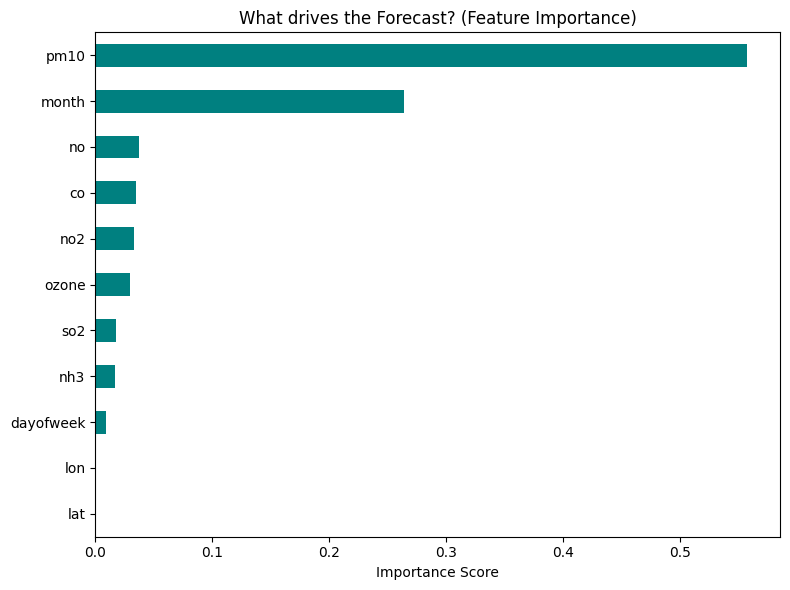

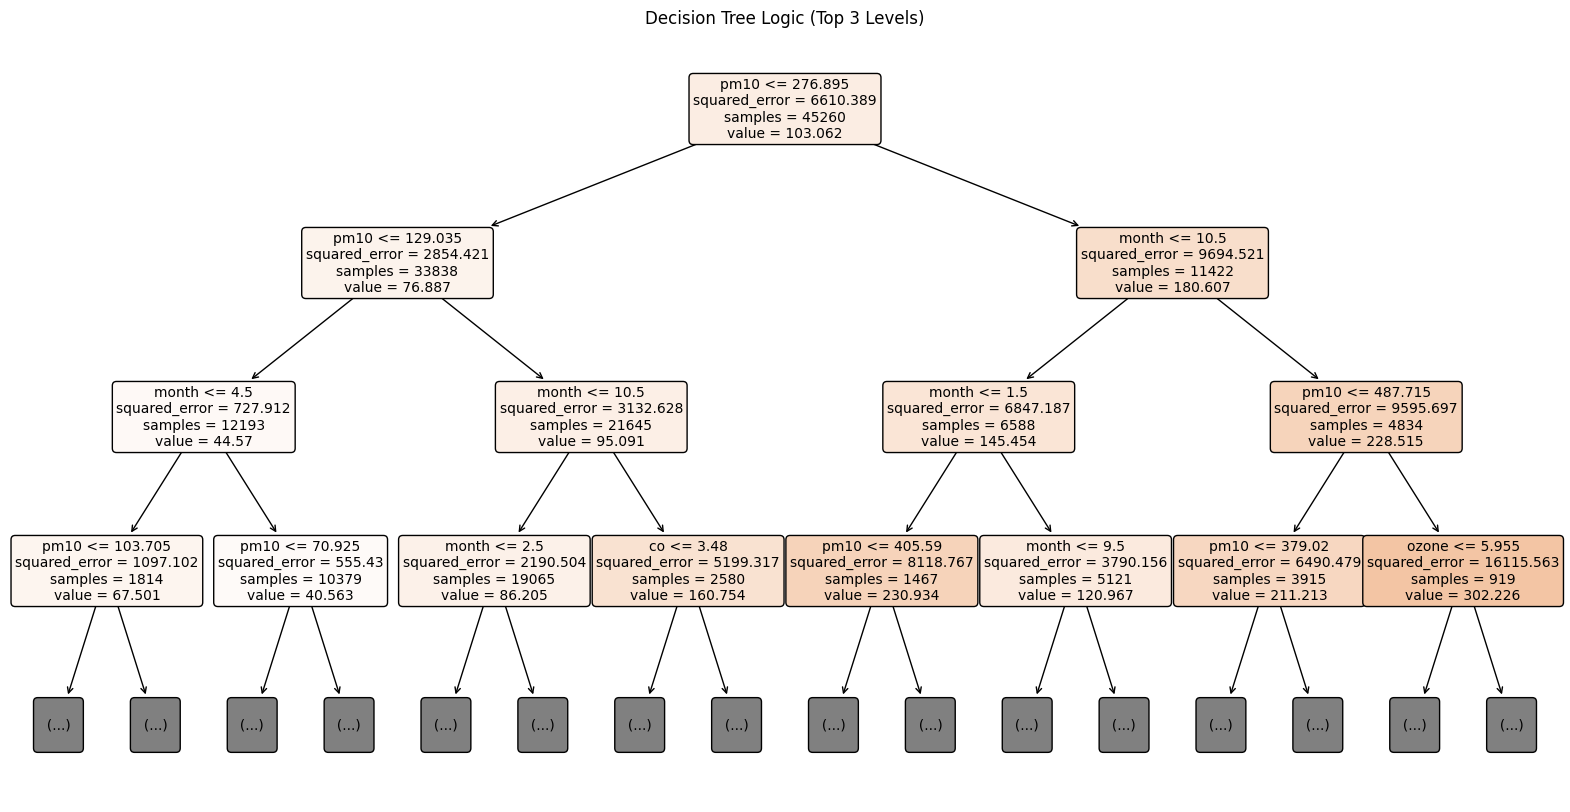

Saved tree image -> /kaggle/working/outputs/dt_tree.png


In [195]:
# ===============================================
# FIXED BLOCK 4 — Evaluate Forecasting Model (Detailed)
# ===============================================

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import plot_tree, export_text
import plotly.graph_objects as go
import os, warnings

warnings.filterwarnings("ignore")

# 1. LOAD PREDICTIONS (Generated in Block 3)
# We use the saved predictions to ensure we evaluate exactly what the model predicted
try:
    results = pd.read_csv("/kaggle/working/dt_predictions.csv", parse_dates=['timestamp'])
    print(f"Loaded {len(results)} test predictions.")
except FileNotFoundError:
    raise RuntimeError("Error: 'dt_predictions.csv' not found. You must run Block 3 first!")

# 2. LOAD MODEL (For visualization)
model_path = "/kaggle/working/models/decision_tree_pm25_forecaster.pkl"
try:
    dt = joblib.load(model_path)
    print("Model loaded successfully.")
except:
    print("Warning: Model file not found. Visualizations might fail.")

# 3. CALCULATE METRICS
# Note: We compare 'Actual_Tomorrow' vs 'Predicted_Tomorrow'
y_test = results['Actual_Tomorrow']
y_pred = results['Predicted_Tomorrow']

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"\n--- FORECASTING PERFORMANCE (Predicting Tomorrow) ---")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2:   {r2:.3f}")

# 4. FAILURE STATISTICS
# Calculate Absolute Error
results['Abs_Error'] = (results['Actual_Tomorrow'] - results['Predicted_Tomorrow']).abs()

pct_fail_30 = (results['Abs_Error'] > 30).mean() * 100
pct_fail_50 = (results['Abs_Error'] > 50).mean() * 100

print(f"Percent predictions with error > 30: {pct_fail_30:.2f}%")
print(f"Percent predictions with error > 50: {pct_fail_50:.2f}%")

# Top 10 Worst Failures (Missed Spikes)
# We specifically look for days where pollution was HIGH, but error was HUGE
worst_failures = results.sort_values(by='Abs_Error', ascending=False).head(10)

print("\n--- TOP 10 WORST FORECAST FAILURES ---")
cols_to_show = ['timestamp', 'site_clean', 'Actual_Tomorrow', 'Predicted_Tomorrow', 'Abs_Error']
# Check if columns exist (site_clean might be missing if not saved)
valid_cols = [c for c in cols_to_show if c in results.columns]
display(worst_failures[valid_cols])

# Save Failure Table
os.makedirs("/kaggle/working/outputs", exist_ok=True)
worst_failures.to_csv("/kaggle/working/outputs/dt_top10_failures.csv", index=False)
print("Saved -> /kaggle/working/outputs/dt_top10_failures.csv")

# 5. PLOT: Actual vs Predicted (Last 120 Days)
# We take the last 120 days of the test set to make the chart readable
subset = results.tail(120)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=subset['timestamp'], y=subset['Actual_Tomorrow'],
    mode='lines', name='Actual (Tomorrow)', line=dict(color='black')
))
fig.add_trace(go.Scatter(
    x=subset['timestamp'], y=subset['Predicted_Tomorrow'],
    mode='lines', name='Predicted (Tomorrow)', line=dict(color='orange', dash='dash')
))
fig.update_layout(
    title="Forecast: Actual vs Predicted (Last 120 Test Days)",
    xaxis_title="Date",
    yaxis_title="PM2.5 Level",
    template='plotly_white'
)
fig.show()

# 6. FEATURE IMPORTANCE PLOT
if 'dt' in locals():
    # Get feature names from the model if possible, or use fallback
    if hasattr(dt, "feature_names_in_"):
        features = dt.feature_names_in_
    else:
        # Fallback list if feature names weren't saved in the object
        features = ["pm10","no","no2","nh3","so2","co","ozone","lat","lon","month","dayofweek"]
        features = features[:dt.n_features_in_]

    imp = pd.Series(dt.feature_importances_, index=features).sort_values(ascending=True)
    
    plt.figure(figsize=(8,6))
    imp.plot(kind='barh', color='teal')
    plt.title("What drives the Forecast? (Feature Importance)")
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.savefig("/kaggle/working/outputs/dt_feature_importance.png", dpi=180)
    plt.show()

# 7. SAVE TREE IMAGE
if 'dt' in locals():
    plt.figure(figsize=(20,10))
    plot_tree(dt, feature_names=features, fontsize=10, filled=True, rounded=True, max_depth=3)
    plt.title("Decision Tree Logic (Top 3 Levels)")
    plt.savefig("/kaggle/working/outputs/dt_tree.png", dpi=200, bbox_inches='tight')
    plt.show()
    print("Saved tree image -> /kaggle/working/outputs/dt_tree.png")

In [ ]:
# assosiation Rule mining 


Mining patterns from 56606 daily records...

--- DISCOVERED RULES: What causes Hazardous Air? ---
No rules found. Try lowering min_support or min_threshold.


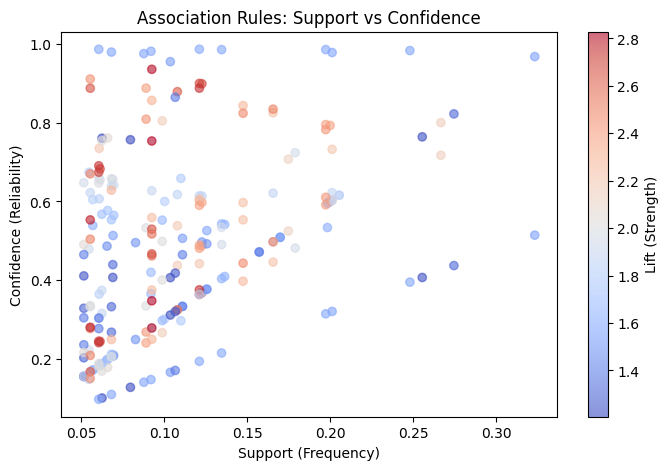

In [198]:
# ===============================================
# BLOCK 5 — Association Rule Mining (Pattern Discovery)
# ===============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules

# 1. LOAD DATA
# We use the raw preprocessed file to find patterns in the input data
try:
    df = pd.read_csv("/kaggle/working/MLDelhi2022_preprocessed.csv", parse_dates=['timestamp'])
except:
    df = pd.read_csv("/kaggle/input/delhihel/MLDelhi2022.csv", parse_dates=['Timestamp'])
    df.columns = [c.lower().strip() for c in df.columns]

# 2. FEATURE ENGINEERING (Create Categories)
# Apriori requires "Categories" (Text), not "Numbers".
subset = df.copy()

# A. Discretize Pollutants (Low/Med/High)
# We split data into 3 buckets: Low (bottom 33%), Med, High (top 33%)
def make_bins(col, name):
    return pd.qcut(col, 3, labels=[f"{name}=Low", f"{name}=Med", f"{name}=High"])

subset['PM2.5_Level'] = make_bins(subset['pm25'], 'PM2.5')
subset['NO2_Level']   = make_bins(subset['no2'], 'NO2')

# B. Create Season (Crucial for Delhi patterns)
# Winter = 12,1,2 | Summer = 3,4,5,6 | Monsoon = 7,8,9 | Post-Monsoon = 10,11
def get_season(month):
    if month in [12, 1, 2]: return 'Season=Winter'
    elif month in [3, 4, 5, 6]: return 'Season=Summer'
    elif month in [7, 8, 9]: return 'Season=Monsoon'
    else: return 'Season=PostMonsoon' # This captures Diwali/Stubble burning time

subset['Season'] = subset['timestamp'].dt.month.apply(get_season)

# C. Define "Hazardous" Air (The Target)
# We want to know what causes AQI > 250
subset['Status'] = subset['aqi'].apply(lambda x: 'Air=Hazardous' if x > 250 else 'Air=Safe')

# 3. PREPARE TRANSACTIONS
# Select only categorical columns
cols_to_mine = ['PM2.5_Level', 'NO2_Level', 'Season', 'Status']
data_cat = subset[cols_to_mine].dropna()

# One-Hot Encoding (Required for Apriori)
data_onehot = pd.get_dummies(data_cat).astype(bool)

print(f"Mining patterns from {len(data_onehot)} daily records...")

# 4. RUN APRIORI ALGORITHM
# min_support=0.05 -> Pattern must appear in at least 5% of records
frequent_sets = apriori(data_onehot, min_support=0.05, use_colnames=True)

# 5. GENERATE RULES
# Lift > 1.2 means the association is strong
rules = association_rules(frequent_sets, metric="lift", min_threshold=1.2)

# 6. FILTER: What leads to 'Air=Hazardous'?
hazardous_rules = rules[
    rules['consequents'].apply(lambda x: 'Air=Hazardous' in list(x))
].sort_values(by='lift', ascending=False)

print(f"\n--- DISCOVERED RULES: What causes Hazardous Air? ---")
if not hazardous_rules.empty:
    cols = ['antecedents', 'consequents', 'support', 'confidence', 'lift']
    # Show top 10 rules
    print(hazardous_rules[cols].head(10))
else:
    print("No rules found. Try lowering min_support or min_threshold.")

# 7. VISUALIZATION
plt.figure(figsize=(8, 5))
plt.scatter(rules['support'], rules['confidence'], alpha=0.6, c=rules['lift'], cmap='coolwarm')
plt.colorbar(label='Lift (Strength)')
plt.xlabel('Support (Frequency)')
plt.ylabel('Confidence (Reliability)')
plt.title('Association Rules: Support vs Confidence')
plt.show()

In [ ]:
# BLOCK A — SAFE SAMPLE → One-hot → Apriori

import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

# Load full basket
basket = pd.read_csv("/kaggle/working/apriori_data/transaction_daily.csv")

# ------------------------------
# 1) Select important columns only
# ------------------------------
use_cols = [
    "pm25_bin",
    "pm10_bin",
    "PM25_Exceed",
    "PM10_Exceed",
    "Season",
    "Diwali",
    "CropBurning",
    "is_weekend"
]
basket = basket[use_cols]

# ------------------------------
# 2) Take a SMALL STRATIFIED SAMPLE
# ------------------------------
sample_size = 40000  # safe size
basket_sample = basket.sample(n=min(sample_size, len(basket)), random_state=42)

print("Sample size:", basket_sample.shape)

# ------------------------------
# 3) One-hot encode sample
# ------------------------------
encoded = pd.get_dummies(basket_sample)
print("Encoded shape:", encoded.shape)

# ------------------------------
# 4) Apriori (very fast now)
# ------------------------------
freq = apriori(encoded, min_support=0.05, use_colnames=True)
print("Frequent itemsets:", freq.shape[0])
display(freq.head())


In [ ]:
# BLOCK B — Rules from sample + graph

import networkx as nx
import matplotlib.pyplot as plt

# Rules
rules = association_rules(freq, metric="confidence", min_threshold=0.6)
rules = rules.sort_values("lift", ascending=False)

print("Rules found:", rules.shape[0])
display(rules.head(10))

# Strong rules (best for slide)
strong = rules[(rules["lift"] > 1.2) & (rules["confidence"] > 0.7)]
print("Strong rules:", strong.shape[0])
display(strong.head(10))

# ---- Graph of top rules ----
top = strong.head(8)
G = nx.DiGraph()

for _, r in top.iterrows():
    for a in r["antecedents"]:
        for c in r["consequents"]:
            G.add_edge(a, c, weight=r["lift"])

plt.figure(figsize=(10,6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos,
        with_labels=True,
        node_size=2600,
        node_color="orange",
        edge_color="gray",
        arrows=True,
        font_size=9)
plt.title("Apriori Rule Network (Sampled Data)")
plt.show()


In [ ]:
# clustring

In [ ]:
# BLOCK 1 — Station summary features (daily -> station aggregates)
import pandas as pd
import numpy as np
out_dir = "/kaggle/working/clustering"
import os
os.makedirs(out_dir, exist_ok=True)

df = pd.read_csv("/kaggle/working/MLDelhi2022_preprocessed.csv", parse_dates=["timestamp"], low_memory=False)
df = df.dropna(subset=["site_clean", "timestamp"]).reset_index(drop=True)

# ensure lower-case columns (defensive)
df.columns = [c.strip() for c in df.columns]

# create date and season
df["date"] = pd.to_datetime(df["timestamp"]).dt.date
df["month"] = pd.to_datetime(df["timestamp"]).dt.month
season_map = {12:"Winter",1:"Winter",2:"Winter",3:"Spring",4:"Spring",5:"Summer",6:"Summer",7:"Monsoon",8:"Monsoon",9:"Autumn",10:"Autumn",11:"Autumn"}
df["season"] = df["month"].map(season_map)

# numeric pollutants to summarize (keep only existing)
polls = [c for c in ["pm25","pm10","no","no2","nh3","so2","co","ozone"] if c in df.columns]

# daily station mean (reduce rows)
daily = df.groupby(["site_clean","date"])[polls].mean().reset_index()

# station summary features
agg_funcs = {}
for p in polls:
    agg_funcs[p] = ["mean","median","std","max"]
station_stats = daily.groupby("site_clean").agg(agg_funcs)
# flatten columns
station_stats.columns = ["_".join(col).strip() for col in station_stats.columns.values]
station_stats = station_stats.reset_index()

# WHO exceedance % & extreme days from daily
if "pm25" in daily.columns:
    exceed = daily.groupby("site_clean").apply(lambda g: (g["pm25"]>25).mean()*100).reset_index(name="pm25_exceed_pct")
    extreme = daily.groupby("site_clean").apply(lambda g: (g["pm25"]>300).sum()).reset_index(name="pm25_extreme_days")
    station_stats = station_stats.merge(exceed, on="site_clean", how="left").merge(extreme, on="site_clean", how="left")
else:
    station_stats["pm25_exceed_pct"] = 0
    station_stats["pm25_extreme_days"] = 0

# seasonal means
season_means = df.groupby(["site_clean","season"])[polls].mean().reset_index()
# pivot to columns like pm25_winter_mean
for s in ["Winter","Monsoon","Summer","Autumn","Spring"]:
    tmp = season_means[season_means["season"]==s].set_index("site_clean")[polls].add_suffix("_"+s.lower()+"_mean")
    station_stats = station_stats.merge(tmp.reset_index(), on="site_clean", how="left")

# attach lat/lon median
if "lat" in df.columns and "lon" in df.columns:
    loc = df.groupby("site_clean").agg({"lat":"median","lon":"median"}).reset_index()
    station_stats = station_stats.merge(loc, on="site_clean", how="left")
else:
    station_stats["lat"] = np.nan; station_stats["lon"] = np.nan

# save
station_stats.to_csv(f"{out_dir}/station_summary_features.csv", index=False)
print("Saved station summary:", f"{out_dir}/station_summary_features.csv")
display(station_stats.head())


In [200]:
# ===============================================
# BLOCK 6 — PCA + KMeans Clustering (Fixed)
# ===============================================

import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 1. LOAD DATA
try:
    df = pd.read_csv("/kaggle/working/clustering/station_summary_features.csv")
except FileNotFoundError:
    raise RuntimeError("Error: Run the previous 'Station Summary' block first!")

# 2. PREPARE DATA
# Save meta-data
meta_cols = ['site_clean', 'lat', 'lon']
meta = df[[c for c in meta_cols if c in df.columns]].copy()

# Drop non-numeric
data_numeric = df.drop(columns=meta_cols, errors='ignore')
data_numeric = data_numeric.fillna(data_numeric.median())

# 3. SCALE
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_numeric)

# 4. PCA (Flexible)
# We ask for 95% variance, but if that results in 1 component, we force 2 for plotting
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# --- THE FIX: Ensure we have at least 2 dimensions for the plot ---
n_components = X_pca.shape[1]
print(f"PCA reduced features to: {n_components} components")

if n_components < 2:
    print("re-running PCA with n_components=2 for visualization purposes...")
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    n_components = 2

# 5. FIND OPTIMAL K
scores = {}
best_k = 3
best_score = -1

for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_pca)
    if len(set(labels)) < 2: continue
    score = silhouette_score(X_pca, labels)
    if score > best_score:
        best_score = score
        best_k = k

print(f"Best K selected: {best_k}")

# 6. FINAL CLUSTERING
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)

meta['Cluster'] = clusters
meta['Label'] = "Zone " + meta['Cluster'].astype(str)

# 7. SAVE RESULTS
meta.to_csv("/kaggle/working/clustering/station_clusters.csv", index=False)
print("Saved -> /kaggle/working/clustering/station_clusters.csv")

# 8. VISUALIZE
# Dynamically create column names
cols = [f'PC{i+1}' for i in range(n_components)]
pca_df = pd.DataFrame(X_pca, columns=cols)
pca_df['Station'] = meta['site_clean']
pca_df['Cluster'] = meta['Label']

# Plot first 2 components
fig = px.scatter(
    pca_df, x='PC1', y='PC2', 
    color='Cluster', 
    hover_name='Station',
    title=f"Station Clusters (PCA Visualization, K={best_k})",
    template='plotly_white'
)
fig.show()

PCA reduced features to: 1 components
re-running PCA with n_components=2 for visualization purposes...
Best K selected: 3
Saved -> /kaggle/working/clustering/station_clusters.csv


In [202]:
# ===============================================
# BLOCK 7 — Cluster Visualization & Mapping
# ===============================================

import pandas as pd
import plotly.express as px
import folium
from folium.plugins import MarkerCluster
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. LOAD DATA
# Load the detailed features
stations = pd.read_csv("/kaggle/working/clustering/station_summary_features.csv")
# Load the cluster labels we just created
clusters = pd.read_csv("/kaggle/working/clustering/station_clusters.csv")

# 2. SAFE MERGE (The Fix)
# We merge on 'site_clean' to ensure the right station gets the right cluster
# We only need the 'Cluster' and 'Label' columns from the clusters file
if 'Label' in clusters.columns:
    dfc = pd.merge(stations, clusters[['site_clean', 'Cluster', 'Label']], on='site_clean', how='inner')
else:
    dfc = pd.merge(stations, clusters[['site_clean', 'Cluster']], on='site_clean', how='inner')
    dfc['Label'] = "Cluster " + dfc['Cluster'].astype(str)

print(f"Merged Data Shape: {dfc.shape}")

# ======================================================
# 1. PCA SCATTER PLOT (Visual Proof of Separation)
# ======================================================

# Select numeric columns for PCA (exclude text/meta)
non_numeric = ["site_clean", "lat", "lon", "Cluster", "Label", "season"]
num_cols = [c for c in dfc.columns if c not in non_numeric]

# Scale
Xs = StandardScaler().fit_transform(dfc[num_cols].fillna(0))

# PCA
pca = PCA(n_components=2, random_state=42)
Xp2 = pca.fit_transform(Xs)
dfc["PC1"] = Xp2[:,0]
dfc["PC2"] = Xp2[:,1]

fig = px.scatter(
    dfc, x="PC1", y="PC2", color="Label",
    hover_data=["site_clean"],
    title="Station Clusters: Visualizing Separation (PCA)",
    template="plotly_white"
)
fig.show()

# ======================================================
# 2. FOLIUM MAP (The "Cool Factor")
# ======================================================

# Define colors for clusters
# 0=Green, 1=Orange, 2=Red (Approximate mapping, adjust based on your results)
colors = ["green", "orange", "red", "purple", "blue"]

# Create Map centered on Delhi
m = folium.Map(location=[28.6, 77.2], zoom_start=10, tiles="cartodbpositron")
mc = MarkerCluster().add_to(m)

for _, row in dfc.iterrows():
    # Pick color safely (modulo in case you have >5 clusters)
    color_idx = int(row["Cluster"]) % len(colors)
    
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=10,
        color=colors[color_idx],
        fill=True,
        fill_color=colors[color_idx],
        fill_opacity=0.7,
        popup=f"<b>{row['site_clean']}</b><br>Zone: {row['Label']}<br>Avg PM2.5: {row.get('pm25_mean', 'N/A'):.1f}"
    ).add_to(mc)

# Display Map
display(m)

# ======================================================
# 3. POLLUTANT COMPARISON (Bar Chart)
# ======================================================

# We compare the average pollution levels of each cluster
poll_cols = [c for c in dfc.columns if "_mean" in c and ("pm25" in c or "no2" in c)]
cluster_means = dfc.groupby("Label")[poll_cols].mean().reset_index()

fig2 = px.bar(
    cluster_means, x="Label", y=poll_cols,
    title="Pollution Profile: How do the zones differ?",
    barmode="group",
    template="plotly_white"
)
fig2.show()

Merged Data Shape: (31, 79)


In [ ]:
import pandas as pd
import plotly.express as px

# Load cluster results
df_clusters = pd.read_csv("/kaggle/working/clustering/station_clusters.csv")

# Load full features (has site_clean & correct lat/lon)
df_full = pd.read_csv("/kaggle/working/clustering/station_summary_features.csv")

# Merge properly by site_clean
df = df_full.merge(
    df_clusters[["lat", "lon", "cluster"]], 
    left_on="lat", 
    right_on="lat",
    how="left"
)

# If lon column got duplicated → fix it
if "lon_x" in df.columns and "lon_y" in df.columns:
    # decide which lon to use (lon_x is original clean one)
    df = df.rename(columns={"lon_x": "lon"})
    df = df.drop(columns=["lon_y"], errors="ignore")

# If still no lon, fallback to df_full
if "lon" not in df.columns:
    df["lon"] = df_full["lon"]

# Print columns to confirm
print("Columns:", df.columns.tolist())

# --- Plot ---
fig = px.scatter_mapbox(
    df,
    lat="lat",
    lon="lon",
    color="cluster",
    hover_name="site_clean",
    hover_data={
        "pm25_mean": True,
        "pm25_exceed_pct": True,
    },
    zoom=10,
    height=700,
    color_discrete_sequence=px.colors.qualitative.Set1
)

fig.update_layout(
    mapbox_style="carto-positron",
    title="Delhi Pollution Station Clusters (KMeans)",
    title_x=0.5,
    margin=dict(r=0, t=50, l=0, b=0)
)

fig.show()


In [ ]:
# LSTM prediction


In [203]:
# ===============================================
# BLOCK 8 — Data Prep for LSTM (7-Day Forecast)
# ===============================================

import pandas as pd
import numpy as np
import os
import joblib
from sklearn.preprocessing import MinMaxScaler

# 1. SETUP
# We will look back 30 days to predict the next 7 days
N_PAST = 30
N_OUT = 7
OUT_DIR = "/kaggle/working/lstm_aqi"
os.makedirs(OUT_DIR, exist_ok=True)

# 2. LOAD DATA
try:
    df = pd.read_csv("/kaggle/working/MLDelhi2022_preprocessed.csv", parse_dates=["timestamp"])
except:
    df = pd.read_csv("/kaggle/input/delhihel/MLDelhi2022.csv", parse_dates=["Timestamp"])
    df.rename(columns={'Timestamp':'timestamp'}, inplace=True)
    df.columns = [c.lower().strip() for c in df.columns]

# 3. CREATE DAILY AVERAGE (City-Wide)
# LSTM works best on a single time-series first. We average all stations to get "Delhi's AQI"
if "aqi" in df.columns:
    daily = df.set_index("timestamp").resample("D")["aqi"].mean().reset_index()
    target_col = "aqi"
elif "pm25" in df.columns:
    print("Warning: 'AQI' column missing. Using 'PM2.5' as proxy.")
    daily = df.set_index("timestamp").resample("D")["pm25"].mean().reset_index()
    target_col = "pm25"
    daily.rename(columns={"pm25": "aqi"}, inplace=True)
else:
    raise ValueError("No AQI or PM2.5 data found!")

# Interpolate small gaps (up to 3 days)
daily[target_col] = daily[target_col].interpolate(limit=3)
daily = daily.dropna().reset_index(drop=True)

print(f"Daily Series Length: {len(daily)} days")

# 4. SCALE DATA (0 to 1)
# LSTMs are sensitive to scale. We must normalize.
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(daily[[target_col]])

# Save scaler for later (to inverse transform predictions)
joblib.dump(scaler, os.path.join(OUT_DIR, "scaler_aqi.save"))

# 5. BUILD SEQUENCES (Sliding Window)
# X = [Day 1..30], Y = [Day 31..37]
X, Y = [], []

for i in range(N_PAST, len(data_scaled) - N_OUT + 1):
    X.append(data_scaled[i-N_PAST:i, 0])
    Y.append(data_scaled[i:i+N_OUT, 0])

X = np.array(X)
Y = np.array(Y)

# Reshape X for LSTM [Samples, TimeSteps, Features]
# Features = 1 (just AQI)
X = X.reshape((X.shape[0], X.shape[1], 1))

print(f"Sequence Shape: X={X.shape}, Y={Y.shape}")

# 6. SPLIT TRAIN/TEST (Sequential)
# Last 90 days for testing
test_size = 90
train_size = len(X) - test_size

X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

print(f"Train samples: {len(X_train)} | Test samples: {len(X_test)}")

# 7. SAVE NUMPY ARRAYS
np.save(os.path.join(OUT_DIR, "X_train.npy"), X_train)
np.save(os.path.join(OUT_DIR, "X_test.npy"), X_test)
np.save(os.path.join(OUT_DIR, "Y_train.npy"), Y_train)
np.save(os.path.join(OUT_DIR, "Y_test.npy"), Y_test)
daily.to_csv(os.path.join(OUT_DIR, "daily_aqi_series.csv"), index=False)

print("LSTM Data Ready in:", OUT_DIR)

Daily Series Length: 1826 days
Sequence Shape: X=(1790, 30, 1), Y=(1790, 7)
Train samples: 1700 | Test samples: 90
LSTM Data Ready in: /kaggle/working/lstm_aqi


In [204]:
# ===============================================
# BLOCK 9 — LSTM Training & 7-Day Forecast
# ===============================================

import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import plotly.graph_objects as go
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. LOAD PREPARED DATA
OUT_DIR = "/kaggle/working/lstm_aqi"
try:
    X_train = np.load(os.path.join(OUT_DIR, "X_train.npy"))
    X_test  = np.load(os.path.join(OUT_DIR, "X_test.npy"))
    Y_train = np.load(os.path.join(OUT_DIR, "Y_train.npy"))
    Y_test  = np.load(os.path.join(OUT_DIR, "Y_test.npy"))
    daily   = pd.read_csv(os.path.join(OUT_DIR, "daily_aqi_series.csv"), parse_dates=["timestamp"])
    scaler  = joblib.load(os.path.join(OUT_DIR, "scaler_aqi.save"))
    print("LSTM Data Loaded Successfully.")
except FileNotFoundError:
    raise RuntimeError("Error: Data files not found. You must run the 'LSTM Data Prep' block first!")

n_past = X_train.shape[1]
n_out = Y_train.shape[1]
print(f"Input Sequence: {n_past} days | Output Horizon: {n_out} days")

# 2. BUILD MODEL
tf.random.set_seed(42)
model = Sequential([
    LSTM(64, input_shape=(n_past, 1), return_sequences=False),
    Dropout(0.2),
    Dense(64, activation="relu"),
    Dense(n_out, activation="linear")   # Direct output for 7 days
])

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

# 3. TRAIN
ckpt = os.path.join(OUT_DIR, "lstm_best.h5")
es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
mc = ModelCheckpoint(ckpt, monitor="val_loss", save_best_only=True, verbose=0)

print("Starting Training (Approx 1-2 mins)...")
history = model.fit(
    X_train, Y_train,
    validation_split=0.1,
    epochs=50,  # 50 is usually enough for this data size
    batch_size=32,
    callbacks=[es, mc],
    verbose=0  # Silent training to keep notebook clean
)
print("Training Complete.")

# 4. EVALUATE (Inverse Transform to get real AQI values)
Y_pred_scaled = model.predict(X_test)

def inv_scale(sequence_scaled):
    # Reshape to 2D for inverse_transform
    flat = sequence_scaled.reshape(-1, 1)
    inv = scaler.inverse_transform(flat)
    return inv.reshape(sequence_scaled.shape)

Y_test_inv = inv_scale(Y_test)
Y_pred_inv = inv_scale(Y_pred_scaled)

# Calculate Error for each day (Day 1, Day 2... Day 7)
maes = np.mean(np.abs(Y_test_inv - Y_pred_inv), axis=0)
rmses = np.sqrt(np.mean((Y_test_inv - Y_pred_inv)**2, axis=0))

print("\n--- 7-DAY FORECAST ACCURACY ---")
for i in range(n_out):
    print(f"Day +{i+1}: MAE = {maes[i]:.2f} | RMSE = {rmses[i]:.2f}")

overall_mae = mean_absolute_error(Y_test_inv.flatten(), Y_pred_inv.flatten())
print(f"\nOverall Average MAE: {overall_mae:.2f}")

# 5. VISUALIZE: Actual vs Predicted (Last Test Sample)
# We grab the very last test window to see how well we predicted the most recent week
idx = -1 
actual_week = Y_test_inv[idx]
pred_week   = Y_pred_inv[idx]

# Generate hypothetical dates for the plot
last_known_date = daily["timestamp"].max()
plot_dates = [last_known_date + pd.Timedelta(days=i) for i in range(1, 8)]

fig = go.Figure()
fig.add_trace(go.Bar(x=plot_dates, y=actual_week, name="Actual AQI", marker_color="gray"))
fig.add_trace(go.Scatter(x=plot_dates, y=pred_week, name="LSTM Forecast", line=dict(color="orange", width=4)))
fig.update_layout(title="LSTM Performance: Predicting the Final Week", template="plotly_white")
fig.show()

# 6. FUTURE FORECAST (Real Next 7 Days)
# Use the very last data available in X_test as input
last_input_window = X_test[-1].reshape(1, n_past, 1)
future_scaled = model.predict(last_input_window)
future_aqi = inv_scale(future_scaled)[0]

print("\n--- FUTURE AQI FORECAST (Next 7 Days) ---")
for i, val in enumerate(future_aqi):
    print(f"Day +{i+1}: {val:.1f}")

# Save Forecast
forecast_df = pd.DataFrame({
    "Day": [f"Day +{i}" for i in range(1, 8)],
    "Predicted_AQI": future_aqi
})
forecast_df.to_csv(os.path.join(OUT_DIR, "final_7day_forecast.csv"), index=False)
print("Forecast saved to final_7day_forecast.csv")

LSTM Data Loaded Successfully.
Input Sequence: 30 days | Output Horizon: 7 days


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,511 (84.03 KB)

 Trainable params: 21,511 (84.03 KB)

 Non-trainable params: 0 (0.00 B)

Starting Training (Approx 1-2 mins)...


Training Complete.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step

--- 7-DAY FORECAST ACCURACY ---
Day +1: MAE = 55.19 | RMSE = 64.10
Day +2: MAE = 61.09 | RMSE = 71.41
Day +3: MAE = 68.10 | RMSE = 79.22
Day +4: MAE = 70.14 | RMSE = 82.50
Day +5: MAE = 73.93 | RMSE = 86.69
Day +6: MAE = 79.86 | RMSE = 93.62
Day +7: MAE = 81.85 | RMSE = 96.67

Overall Average MAE: 70.02


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

--- FUTURE AQI FORECAST (Next 7 Days) ---
Day +1: 315.3
Day +2: 316.9
Day +3: 306.4
Day +4: 309.6
Day +5: 306.3
Day +6: 297.1
Day +7: 294.7
Forecast saved to final_7day_forecast.csv


In [207]:
# BLOCK 3 — 7-Day AQI Forecast Using LSTM (Final Output)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import joblib
import os

OUT_DIR = "/kaggle/working/lstm_aqi"
MODEL_PATH = os.path.join(OUT_DIR, "lstm_best.h5")  # change to .keras if needed
SCALER_PATH = os.path.join(OUT_DIR, "scaler.pkl")

# === Load trained model & scaler ===
model = load_model(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)

print("Model & scaler loaded.")

# === Load original cleaned time series ===
df = pd.read_csv("/kaggle/working/MLDelhi2022_preprocessed.csv", parse_dates=["timestamp"])
df = df.dropna(subset=["pm25"]).sort_values("timestamp").reset_index(drop=True)

# === Extract the last 30 days for prediction ===
n_past = 30
n_future = 7

last_window = df["pm25"].values[-n_past:].reshape(-1, 1)

# Scale
last_window_scaled = scaler.transform(last_window)

# === LSTM expects shape (1, time_steps, features) ===
input_seq = np.expand_dims(last_window_scaled, axis=0)

# === Predict next 7 days (scaled) ===
pred_scaled = model.predict(input_seq)[0]

# Inverse transform back to original AQI scale
pred = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()

# === Build date range for forecast ===
last_date = df["timestamp"].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_future)

forecast_df = pd.DataFrame({
    "date": future_dates,
    "predicted_pm25": pred
})

display(forecast_df)

# === Plot prediction ===
plt.figure(figsize=(12,5))

# last actual 30 days
plt.plot(df["timestamp"].iloc[-30:], df["pm25"].iloc[-30:], color="black", label="Last 30 Days Actual PM2.5")

# next 7 days forecast
plt.plot(future_dates, pred, color="red", marker="o", label="7-Day Forecast")

plt.title("7-Day PM2.5 Forecast (LSTM)")
plt.xlabel("Date")
plt.ylabel("PM2.5 (µg/m³)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


TypeError: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}